## Le Recuit Simulé (Simulated Annealing)

Le **recuit simulé** est une **méthode d'optimisation stochastique** inspirée du processus physique de **recuit métallurgique**, où un métal est chauffé puis refroidi lentement pour atteindre une configuration minimale d'énergie.

### Principe
L'idée est d'explorer l'espace des solutions en acceptant non seulement les améliorations, mais aussi **certaines détériorations temporaires** de la solution. Cela permet d'**éviter les minima locaux**.

### Fonctionnement
1. **Initialisation** : On part d'une solution initiale et d'une température initiale élevée.
2. **Génération de voisin** : À chaque itération, une nouvelle solution voisine est générée.
3. **Évaluation** : Si elle est meilleure, on l'accepte. Si elle est pire, on l'accepte avec une probabilité qui diminue avec la température :
   \[
   P = e^{-\frac{\Delta E}{T}}
   \]
   où :
   - \( \Delta E \) est la variation de coût,
   - \( T \) est la température actuelle.
4. **Refroidissement** : La température est diminuée progressivement selon un **planning de refroidissement** (par exemple, \( T \leftarrow \alpha \cdot T \), avec \( 0 < \alpha < 1 \)).

### Avantages
- Évite les pièges des minima locaux.
- Facile à implémenter.
- Peu de paramètres à ajuster.

### Inconvénients
- Le choix du planning de refroidissement est crucial.
- Peut être lent à converger.

### Applications
- Problèmes combinatoires (comme le voyageur de commerce),
- Optimisation continue,
- Apprentissage automatique, etc.


In [5]:
# Cellule 1: Imports
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt
import math

In [6]:
# Cellule 2: Fonction de chargement des données
def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

## Classe principale du Recuit Simulé

Cette classe implémente l'algorithme de recuit simulé pour résoudre le problème de tournée de véhicules.

Le recuit simulé est une méta-heuristique inspirée du processus physique de recuit en métallurgie. L'algorithme:
1. Part d'une solution initiale
2. Explore l'espace des solutions en acceptant parfois des solutions moins bonnes (pour éviter les minima locaux)
3. Réduit progressivement la "température" pour converger vers une solution optimale

In [7]:
class SimulatedAnnealingTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_random_solution(self) -> List[int]:
        """Génère une solution aléatoire valide."""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                return path

    def get_neighbor(self, path: List[int]) -> List[int]:
        """Génère un voisin valide de la solution actuelle."""
        while True:
            new_path = path.copy()
            
            # On ne modifie pas le départ, l'arrivée ou les points de collecte contraints
            mutable_positions = list(range(1, len(path)-1))
            if len(path) > 3:
                mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
            if len(path) > 4:
                mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
                
            if len(mutable_positions) < 2:
                return path
                
            # Choisir un type de mouvement aléatoire
            move_type = random.choice(['swap', 'inversion', 'insertion'])
            
            if move_type == 'swap':
                # Échange de deux villes
                i, j = random.sample(mutable_positions, 2)
                new_path[i], new_path[j] = new_path[j], new_path[i]
                
            elif move_type == 'inversion':
                # Inversion d'une sous-séquence
                start, end = sorted(random.sample(mutable_positions, 2))
                new_path[start:end+1] = new_path[start:end+1][::-1]
                
            elif move_type == 'insertion':
                # Déplacement d'une ville à une autre position
                i = random.choice(mutable_positions)
                city = new_path.pop(i)
                j = random.choice([p for p in mutable_positions if p != i])
                new_path.insert(j, city)
            
            # Vérifier si le nouveau chemin est valide
            if self.is_valid_path(new_path):
                return new_path

    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.99,
             min_temp: float = 0.1, max_iter: int = 10000):
        """Algorithme de recuit simulé."""
        start_time = time.time()
        
        # Génération de la solution initiale
        current_solution = self._greedy_construction() or self.generate_random_solution()
        current_cost = self.calculate_cost(current_solution)
        
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        self.cost_history.append(current_cost)
        
        temp = initial_temp
        iteration = 0
        
        while temp > min_temp and iteration < max_iter:
            # Générer un voisin
            neighbor = self.get_neighbor(current_solution)
            neighbor_cost = self.calculate_cost(neighbor)
            
            # Calculer la différence de coût
            cost_diff = neighbor_cost - current_cost
            
            # Accepter ou rejeter le voisin
            if cost_diff < 0 or random.random() < math.exp(-cost_diff / temp):
                current_solution = neighbor
                current_cost = neighbor_cost
                
                # Mettre à jour la meilleure solution
                if current_cost < self.best_cost:
                    self.best_solution = current_solution.copy()
                    self.best_cost = current_cost
            
            # Enregistrer le meilleur coût à chaque itération
            self.cost_history.append(self.best_cost)
            
            # Refroidissement
            temp *= cooling_rate
            iteration += 1
            
            # Affichage progression
            if iteration % 100 == 0:
                print(f"Iter {iteration}: Temp={temp:.2f} Best={self.best_cost} Current={current_cost}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

## Validation des solutions

Cette partie implémente les méthodes pour valider les solutions et calculer leur coût.

- `is_valid_path`: Vérifie si un chemin respecte toutes les contraintes
- `calculate_cost`: Calcule le coût total d'une solution (longueur du trajet)

## Génération de solutions initiales

Deux méthodes pour générer des solutions initiales:
1. `_greedy_construction`: Approche gloutonne qui construit la solution pas à pas en choisissant toujours le meilleur mouvement local
2. `generate_random_solution`: Génère une solution aléatoire mais valide

Une bonne solution initiale peut accélérer la convergence de l'algorithme.

## Génération de voisins

La méthode `get_neighbor` génère des solutions voisines en utilisant trois opérations:
1. `swap`: Échange deux villes dans le parcours
2. `inversion`: Inverse une sous-séquence du parcours
3. `insertion`: Déplace une ville à une autre position

Ces opérations permettent d'explorer l'espace des solutions tout en garantissant que les solutions générées restent valides.

## Algorithme de Recuit Simulé

C'est le cœur de l'implémentation. L'algorithme:
1. Part d'une solution initiale
2. À chaque itération:
   - Génère un voisin
   - Décide de l'accepter ou non (en fonction de la température et de l'amélioration)
   - Réduit la température selon un taux de refroidissement
3. Garde trace de la meilleure solution trouvée

Les paramètres clés sont:
- `initial_temp`: Température initiale
- `cooling_rate`: Taux de refroidissement
- `min_temp`: Température minimale avant arrêt
- `max_iter`: Nombre maximum d'itérations

## Choix des paramètres pour l'heuristique de Recuit Simulé (Simulated Annealing)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants sont choisis :

| Taille (nombre de villes) | Température initiale (`T_init`) | Température finale (`T_min`) | Taux de refroidissement (`cooling_rate`) | Nombre d'itérations par température |
|:---|:---|:---|:---|:---|
| 10 | 1000 | 1 | 0.95 | 50 |
| 20 | 2000 | 1 | 0.95 | 100 |
| 30 | 3000 | 1 | 0.95 | 150 |
| 40 | 4000 | 1 | 0.95 | 200 |
| 50 | 5000 | 1 | 0.95 | 250 |
| 75 | 7500 | 1 | 0.95 | 400 |
| 100 | 10000 | 1 | 0.95 | 500 |

### Explication des choix

- **Température initiale (`T_init`)** : proportionnelle au nombre de villes pour permettre une bonne exploration initiale.
- **Température minimale (`T_min`)** : fixée à 1 pour arrêter l'algorithme lorsque les mouvements deviennent insignifiants.
- **Taux de refroidissement (`cooling_rate`)** : fixé à 0.95 pour un refroidissement progressif, équilibrant exploration et exploitation.
- **Nombre d'itérations par température** : croît avec la taille pour mieux exploiter chaque palier de température.


## Exemple d'utilisation

Cette dernière partie montre comment utiliser la classe pour résoudre un problème concret.

## Paramètres :
- initial_temp : Plus elle est élevée, plus l'algo est exploratoire. Il accepte plus facilement des solutions moins bonnes au début
- cooling_rate : Facteur de réduction de la température à chaque itération. Plus il est proche de 1, plus le refroidissement est lent, donc plus de temps pour explorer
- min_temp : Température minimale atteinte avant d'arrêter l'algo. Marque la fin de l'exploration
- max_iter : Nombre max d'itérations autorisées. S'arrête même si la température minimale n'est pas atteinte.

Chargement du fichier C:\Users\alban.calvo\Recherche-Operationnelle\data\matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [96, 56]
- Taille de la matrice: (100, 100)
Iter 100: Temp=6057.70 Best=9515 Current=9874
Iter 200: Temp=3669.58 Best=9470 Current=10581
Iter 300: Temp=2222.92 Best=8188 Current=8698
Iter 400: Temp=1346.58 Best=8188 Current=9979
Iter 500: Temp=815.72 Best=8188 Current=10154
Iter 600: Temp=494.14 Best=8188 Current=10095
Iter 700: Temp=299.33 Best=8188 Current=9104
Iter 800: Temp=181.33 Best=8188 Current=8926
Iter 900: Temp=109.84 Best=7817 Current=8147
Iter 1000: Temp=66.54 Best=7154 Current=7154
Iter 1100: Temp=40.31 Best=6310 Current=6444
Iter 1200: Temp=24.42 Best=5351 Current=5394
Iter 1300: Temp=14.79 Best=5035 Current=5035
Iter 1400: Temp=8.96 Best=4543 Current=4543
Iter 1500: Temp=5.43 Best=4159 Current=4159
Iter 1600: Temp=3.29 Best=3554 Current=3554
Iter 1700: Temp=1.99 Best=3541 Current=

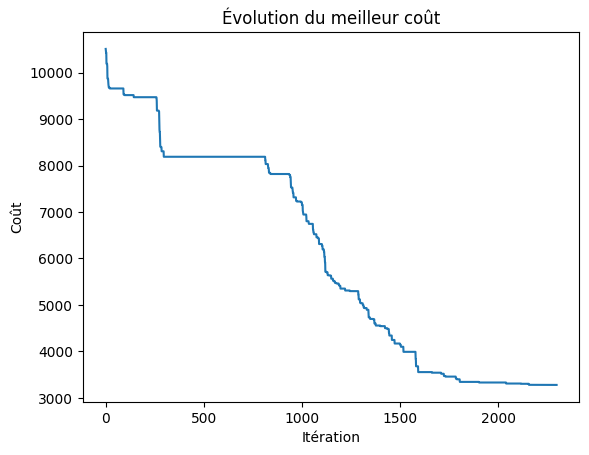


Meilleur chemin trouvé (extrait):
Départ: [1, 96, 24]...[97, 4, 1]
Longueur: 101 villes
Coût total: 3278


In [ ]:
# Cellule 8: Exemple d'utilisation
if __name__ == "__main__":
    try:
        file_path = r"../data/matrice_routes_ordre_generation_aleatoire.csv"  # Remplacez par votre chemin
        print(f"Chargement du fichier {file_path}...")
        matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
        
        print("\nParamètres du problème:")
        print(f"- Nombre de villes: {len(matrix)}")
        print(f"- Points de collecte: {collecte}")
        print(f"- Taille de la matrice: {matrix.shape}")
        
        # Résolution
        solver = SimulatedAnnealingTSP(matrix, collecte)
        solution, cost = solver.solve(
            initial_temp=10000,
            cooling_rate=0.995,
            min_temp=0.1,
            max_iter=5000
        )
        
        print("\nMeilleur chemin trouvé (extrait):")
        print(f"Départ: {solution[:3]}...{solution[-3:]}")
        print(f"Longueur: {len(solution)} villes")
        print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")

## Sources :

- https://www.i2m.univ-amu.fr/perso/jean-philippe.preaux/PDF/pdf_proteges/OptimisationCombinatoire/Metaheuristiques2.pdf
- http://www.lps.ens.fr/~weisbuch/livre/b9.html